Start with baseline CNN inspired by LeNet-5. For this initial investigation, I want to visualize the improvements without considering any domain shifts. I will use the Canine Lymphoma, 3D Histech, VMU Vienna dataset (because it is the largest annotation set).

In [3]:
# Code adapted from Machine Learning Engineering (Cornell Tech 2025)
import torch
import numpy as np
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
from google.colab import drive
import sys
import os

# --- 1. Mount Drive ---
drive.mount('/content/drive')

# --- 2. Define Paths ---
# Path to the source code (loaders.py) - REMAINS ON DRIVE
DRIVE_CODE_PATH = '/content/drive/MyDrive/GoogleColab/dataformidogcnn/'

# Path to the zipped data file on Drive
ZIP_SOURCE_PATH = os.path.join(DRIVE_CODE_PATH, 'cropped_images.zip')

# Local disk folder where the FAST images will be unzipped
FAST_DATA_PATH = '/content/fast_data/'

# --- 3. Unzip Data (Performance Fix) ---
if not os.path.exists(FAST_DATA_PATH):
    print(f"🚀 Unzipping data from Drive to fast local disk: {FAST_DATA_PATH}")
    !mkdir -p "$FAST_DATA_PATH"
    # The -q flag silences the output. -d sets the destination directory.
    !unzip -q "$ZIP_SOURCE_PATH" -d "$FAST_DATA_PATH"

    print("✅ Data transfer complete. Starting new batch load test.")
else:
    print("Fast data directory already exists.")


# --- 4. Set Final Variables ---
# PROJECT_DIR for the rest of your notebook now points to the FAST images
PROJECT_DIR = FAST_DATA_PATH

# Add the Drive path for Python to find 'loaders.py' and other modules
if DRIVE_CODE_PATH not in sys.path:
    sys.path.append(DRIVE_CODE_PATH)
    print(f"✅ Added {DRIVE_CODE_PATH} to Python system path.")

Mounted at /content/drive
🚀 Unzipping data from Drive to fast local disk: /content/fast_data/
✅ Data transfer complete. Starting new batch load test.
✅ Added /content/drive/MyDrive/GoogleColab/dataformidogcnn/ to Python system path.


In [8]:
import pandas as pd
from loaders import create_loaders # This should now work

# Define the full path to your CSV file
CSV_PATH = os.path.join('/content/drive/MyDrive/GoogleColab/dataformidogcnn/', 'processed_annotations_with_patch_id.csv')

# Load the DataFrame and create the df_master variable
try:
    df_master = pd.read_csv(CSV_PATH)
    print(f"✅ df_master loaded successfully. Total rows: {len(df_master)}")
except FileNotFoundError:
    print(f"❌ CRITICAL ERROR: File not found at {CSV_PATH}. Execution stopping here.")
    df_master = None # Prevent NameError in next cell if failed

✅ df_master loaded successfully. Total rows: 26286


In [9]:
import torchvision.transforms as transforms

TARGET_SIZE = 50

# --- Define Your Full Transformation Pipeline ---
custom_transforms = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE), # <-- 60x60 -> 50x50 Crop
    transforms.ToTensor(),
])

custom_filter = {
    'Tumor': 'canine lymphoma',
    'Scanner': '3D Histech',
    'Origin': 'VMU Vienna'
}

# -------------------------------------------------------------

# Call create_loaders, passing the custom pipeline
IMAGE_PATCH_DIR = PROJECT_DIR
# IMAGE_PATCH_DIR now equals '/content/fast_data/cropped_images'

# -------------------------------------------------------------

# Call create_loaders, passing the corrected image patch path
train_loader, val_loader, test_loader = create_loaders(
    df_master,
    patch_dir=IMAGE_PATCH_DIR, # <--- CORRECTED PATH HERE!
    filters=custom_filter,
    transform=custom_transforms
)

print(f"✅ DataLoaders created, pointing to image directory: {IMAGE_PATCH_DIR}")
#

Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32

Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([0, 0, 1, 0, 0])
✅ DataLoaders created, pointing to image directory: /content/fast_data/


In [10]:
batch = next(iter(train_loader))
batch['image'].shape

torch.Size([32, 3, 50, 50])

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Tuple, List

# NOTE: For this code to run, the global 'DEVICE' variable
# (defined in the setup above) must be accessible or passed as an argument.

# Helper function to compute accuracy for a single data loader
def _compute_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device) -> Tuple[int, int]:
    """Computes total correct predictions and total samples for a given dataloader."""
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        # Robust Batch Unpacking (as before)
        if isinstance(batch, dict):
            X_batch = batch.get('image')
            y_batch = batch.get('label')
            if X_batch is None or y_batch is None:
                raise ValueError("DataLoader yields a dict, but 'image' or 'label' keys are missing.")
        elif isinstance(batch, (list, tuple)):
            X_batch, y_batch = batch[0], batch[1]
        else:
            raise TypeError(f"Unexpected batch type: {type(batch)}. Expected tuple, list, or dict.")

        if not isinstance(X_batch, torch.Tensor):
            raise TypeError(f"Input to model is not a Tensor. Type received: {type(X_batch)}.")

        # --- CRITICAL GPU STEP 1: Move data to the device ---
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # ----------------------------------------------------

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, axis=1)

        # Move the results back to the CPU for accurate counting (item() requires CPU)
        total_correct += (predicted == y_batch).sum().item()
        total_samples += y_batch.shape[0]

    return total_correct, total_samples

def evaluate(model: nn.Module, trainloader: torch.utils.data.DataLoader, testloader: torch.utils.data.DataLoader, device: torch.device) -> Tuple[float, float]:
    """
    Calculates the final training and test accuracies.
    """
    model.eval()

    with torch.no_grad():
        # Pass the device to the helper function
        total_correct_train, total_samples_train = _compute_accuracy(model, trainloader, device)
        total_correct_test, total_samples_test = _compute_accuracy(model, testloader, device)

    final_train_accuracy = total_correct_train / total_samples_train if total_samples_train > 0 else 0.0
    final_test_accuracy = total_correct_test / total_samples_test if total_samples_test > 0 else 0.0

    return final_train_accuracy, final_test_accuracy

# (The plot_learning_curves function remains unchanged as it uses CPU plotting libraries)

def train_CNN(model: nn.Module, trainloader: torch.utils.data.DataLoader, testloader: torch.utils.data.DataLoader, num_epochs: int = 50, plot_interval: int = 10, lr: float = 0.01, device: torch.device = None) -> Tuple[float, float]:
    """
    Trains a CNN model with GPU support, evaluates accuracy periodically, and plots the learning curves.
    """
    # 1. Device Setup (Handle if not passed)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Warning: 'device' not passed. Defaulting to {device}.")

    # 2. CRITICAL GPU STEP 2: Move Model to Device (This should ideally be done before calling this function)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    epoch_points = []
    train_acc_points = []
    test_acc_points = []

    # ----------------- Initial Evaluation (Epoch 0) -----------------
    model.eval()
    # Pass the device to evaluate
    train_acc, test_acc = evaluate(model, trainloader, testloader, device)

    epoch_points.append(0)
    train_acc_points.append(train_acc)
    test_acc_points.append(test_acc)

    if plot_interval > 0:
        print(f"Epoch 0 (Initial): Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    # ----------------- TRAINING LOOP -----------------
    for epoch in range(1, num_epochs + 1):

        model.train()

        for batch in trainloader:
            # Robust Batch Unpacking (as before)
            if isinstance(batch, dict):
                X_batch = batch.get('image')
                y_batch = batch.get('label')
            elif isinstance(batch, (list, tuple)):
                X_batch, y_batch = batch[0], batch[1]
            else:
                raise TypeError(f"Unexpected batch type yielded by trainloader: {type(batch)}.")

            if not isinstance(X_batch, torch.Tensor):
                raise TypeError(f"Input image data is not a Tensor. Type received: {type(X_batch)}. ")

            # --- CRITICAL GPU STEP 3: Move data to the device ---
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # ----------------------------------------------------

            # --- Standard Training Steps ---
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ----------------- EVALUATION & STORAGE -----------------
        if (plot_interval != 0 and epoch % plot_interval == 0) or epoch == num_epochs:
            model.eval()
            # Pass the device to evaluate
            train_acc, test_acc = evaluate(model, trainloader, testloader, device)

            epoch_points.append(epoch)
            train_acc_points.append(train_acc)
            test_acc_points.append(test_acc)

            if plot_interval > 0:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

    # ----------------- FINAL PLOT -----------------
    if plot_interval > 0:
        plot_learning_curves(epoch_points, train_acc_points, test_acc_points)

    print(f"\nTraining Complete. Final Train Acc: {train_acc:.4f}, Final Test Acc: {test_acc:.4f}")

    return train_acc, test_acc

def plot_learning_curves(epoch_points: List[int], train_acc_points: List[float], test_acc_points: List[float]):
    """
    Helper function to create the accuracy plot showing training and test accuracy
    over the training epochs.
    """
    plt.figure(figsize=(10, 6))

    # Plotting training accuracy
    plt.plot(epoch_points, train_acc_points, label='Training Accuracy', marker='o')

    # Plotting test/validation accuracy
    plt.plot(epoch_points, test_acc_points, label='Test/Validation Accuracy', marker='x')

    plt.title('Learning Curves: Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
def init_weights(module):
    """Initialize weights for CNNs using He (Kaiming) for ReLU."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        # Use He/Kaiming Uniform initialization
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')

        if module.bias is not None:
            # Initialize biases to zero
            nn.init.constant_(module.bias, 0)

In [ ]:
from torch import nn

class lenet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
accuracies = {}

In [ ]:
model = lenet5()
trainacc, valacc = train_CNN(model, train_loader, val_loader, lr=0.5, device=torch.device("cuda"))
accuracies["lenet5"] = (trainacc, valacc)

In [ ]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = alexnet()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["alexnet"] = (trainacc, valacc)

In [ ]:
class lenet5_relu_max_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader)
accuracies["lenet5_relu_max_dropout"] = (trainacc, valacc)

In [ ]:
class lenet5_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_relu()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_relu"] = (trainacc, valacc)

In [ ]:
class lenet5_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.Sigmoid(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_dropout"] = (trainacc, valacc)

In [ ]:
class lenet5_max(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_max()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_max"] = (trainacc, valacc)

In [ ]:
class lenet5_relu_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_relu_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_relu_dropout"] = (trainacc, valacc)

In [ ]:
class lenet5_relu_max(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_relu_max()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_relu_max"] = (trainacc, valacc)

In [ ]:
class lenet5_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.Sigmoid(),
            nn.LazyLinear(4096), nn.Sigmoid(),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = lenet5_deep()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"))
accuracies["lenet5_deep"] = (trainacc, valacc)

In [ ]:
accuracies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- DATA ASSUMPTION ---
# Assuming 'accuracies' dictionary is available in your environment.
data = accuracies

# 1. Convert to DataFrame and Extract Model ID
df = pd.DataFrame(data).T.reset_index()
df.columns = ['Model ID', 'Train Accuracy', 'Test Accuracy']

# 2. Feature Engineering and Architectural Overrides
def parse_model_features(model_name):
    features = {'Activation Function': 'Sigmoid', 'Pooling Type': 'AvgPool', 'Has Dropout': 'No', 'Architecture Depth': 'Shallow'}

    # Specific Overrides
    if model_name == 'alexnet':
        features.update({'Architecture Depth': 'Deep', 'Activation Function': 'ReLU', 'Pooling Type': 'MaxPool', 'Has Dropout': 'Yes'})
        return pd.Series(features)
    if model_name == 'lenet5_deep':
        features.update({'Architecture Depth': 'Deep', 'Activation Function': 'Sigmoid', 'Pooling Type': 'AvgPool'})
        return pd.Series(features)

    # Generic Features
    if 'relu' in model_name: features['Activation Function'] = 'ReLU'
    if 'max' in model_name: features['Pooling Type'] = 'MaxPool'
    if 'dropout' in model_name: features['Has Dropout'] = 'Yes'
    return pd.Series(features)

df[['Activation Function', 'Pooling Type', 'Has Dropout', 'Architecture Depth']] = df['Model ID'].apply(parse_model_features)

# 3. Sort by Test Accuracy (using float values before formatting)
df = df.sort_values('Test Accuracy', ascending=False)

# 4. Format Accuracy Columns for display
df['Train Accuracy'] = (df['Train Accuracy'] * 100).round(2).astype(str) + '%'
df['Test Accuracy'] = (df['Test Accuracy'] * 100).round(2).astype(str) + '%'

# 5. Select, order, and rename the final columns
final_df = df[[
    'Architecture Depth',
    'Activation Function',
    'Pooling Type',
    'Has Dropout',
    'Train Accuracy',
    'Test Accuracy'
]].reset_index(drop=True)

# Rename the columns for the final display
final_df.columns = [
    'Depth',  # Shortened
    'Activation', # Shortened
    'Pooling',    # Shortened
    'Dropout', # Shortened 'Has Dropout' to 'Dropout'
    'Train Acc.',
    'Test Acc.'
]

# --- MATPLOTLIB VISUALIZATION ---
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, final_df.shape[0] * 0.45))
ax.set_title("Model Architecture and Performance Comparison")
ax.axis('off') # Hide the axes

# Define table properties
table_data = final_df.values
column_labels = final_df.columns

# Set column widths (Adjusted for the new, shorter names)
# Total width must sum to 1.0 (approximately)
colWidths = [0.15, 0.18, 0.15, 0.10, 0.18, 0.18]

# Create the table
table = ax.table(
    cellText=table_data,
    colLabels=column_labels,
    colWidths=colWidths,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.3)

# Apply grid lines and formatting
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('lightgray')

    # Style the header
    if i == 0:
        cell.set_fontsize(11)
        cell.set_facecolor('#f0f0f0')
        cell.set_text_props(weight='bold')

    # Highlight the Test Accuracy column (column index 5)
    if j == 5 and i > 0:
        cell.set_text_props(color='darkblue', weight='bold')

# Display the plot
plt.show()

In [ ]:
import torchvision.transforms as transforms
import os

# --- Configuration (Ensure these match your global settings) ---
TARGET_SIZE = 50
PROJECT_DIR = '/content/fast_data/' # Assuming this is your project root
IMAGE_PATCH_DIR = os.path.join(PROJECT_DIR, 'cropped_images')
# ----------------------------------------------------------------

# --- DEFINE ISOLATED COLOR JITTER OBJECTS ---

# Jitter 1: Brightness Only (Range 0.5)
brightness_aug = transforms.ColorJitter(
    brightness=0.5,
    contrast=0.0,
    saturation=0.0,
    hue=0.0
)
# Jitter 2: Contrast Only (Range 0.5)
contrast_aug = transforms.ColorJitter(
    brightness=0.0,
    contrast=0.5,
    saturation=0.0,
    hue=0.0
)
# Jitter 3: Saturation Only (Range 0.5)
saturation_aug = transforms.ColorJitter(
    brightness=0.0,
    contrast=0.0,
    saturation=0.5,
    hue=0.0
)
# Jitter 4: Hue Only (Range 0.5) <--- NEW OBJECT
hue_aug = transforms.ColorJitter(
    brightness=0.0,
    contrast=0.0,
    saturation=0.0,
    hue=0.5
)


## --- 1. Pipeline for X-Reflections (Horizontal Flip Only) ---
train_transforms_hflip = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.ToTensor(),
])

## --- 2. Pipeline for Y-Reflections (Vertical Flip Only) ---
train_transforms_vflip = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])

# --- 3. Pipeline for BRIGHTNESS Jitter Only ---
train_transforms_brightness = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    brightness_aug,              # Applies Brightness shift only
    transforms.ToTensor(),
])

# --- 4. Pipeline for CONTRAST Jitter Only ---
train_transforms_contrast = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    contrast_aug,                # Applies Contrast shift only
    transforms.ToTensor(),
])

# --- 5. Pipeline for SATURATION Jitter Only ---
train_transforms_saturation = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    saturation_aug,              # Applies Saturation shift only
    transforms.ToTensor(),
])

# --- 6. Pipeline for HUE Jitter Only --- <--- NEW PIPELINE
train_transforms_hue = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    hue_aug,                     # Applies Hue shift only
    transforms.ToTensor(),
])


print("✅ Six distinct augmentation pipelines defined: H-Flip, V-Flip, Brightness Only, Contrast Only, Saturation Only, and Hue Only.")

In [ ]:
# Assuming df_master and custom_filter are defined in your environment
# And that the function 'create_loaders' is accessible
# Also assuming the six new transform pipelines (train_transforms_hflip,
# train_transforms_vflip, train_transforms_brightness, train_transforms_contrast,
# train_transforms_saturation, train_transforms_hue) are defined.

# --- DataLoader 1: Horizontal Flip Test ---
hflip_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_hflip
)
print("✅ DataLoader Set 1 (Horizontal Flip) created.")


# --- DataLoader 2: Vertical Flip Test ---
vflip_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_vflip
)
print("✅ DataLoader Set 2 (Vertical Flip) created.")


# --- DataLoader 3: Brightness Jitter Only Test ---
brightness_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_brightness
)
print("✅ DataLoader Set 3 (Brightness Jitter Only) created.")


# --- DataLoader 4: Contrast Jitter Only Test ---
contrast_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_contrast
)
print("✅ DataLoader Set 4 (Contrast Jitter Only) created.")


# --- DataLoader 5: Saturation Jitter Only Test ---
saturation_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_saturation
)
print("✅ DataLoader Set 5 (Saturation Jitter Only) created.")


# --- DataLoader 6: Hue Jitter Only Test ---
hue_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_hue
)
print("✅ DataLoader Set 6 (Hue Jitter Only) created.")

In [ ]:
class lenet5_relu_max_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
aug_accuracies={}

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["no_augmentation"] = (trainacc, valacc)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, hflip_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["horizonal_flip"] = (trainacc, valacc)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, vflip_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["vertical_flip"] = (trainacc, valacc)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, brightness_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["brightness"] = (trainacc, valacc)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, contrast_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["constrast"] = (trainacc, valacc)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, saturation_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["saturation"] = (trainacc, valacc)

In [ ]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, hue_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
aug_accuracies["hue"] = (trainacc, valacc)

In [ ]:
aug_accuracies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
results = aug_accuracies

# 1. Load data into DataFrame
df = pd.DataFrame(results).T.reset_index()
df.columns = ['Augmentation', 'Train Accuracy', 'Test Accuracy']

# Standardize Augmentation Names for Plotting
df['Augmentation'] = df['Augmentation'].str.replace('_', ' ').str.title().str.replace('Horizonal', 'Horizontal')
df.loc[df['Augmentation'] == 'No Augmentation', 'Augmentation'] = 'Baseline (None)'

# 2. Sort the DataFrame by Test Accuracy
df = df.sort_values(by='Test Accuracy', ascending=False)

# 3. Setup for Grouped Bar Chart
labels = df['Augmentation']
train_acc = df['Train Accuracy']
test_acc = df['Test Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='#1f77b4')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Across Different Augmentation Techniques')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(loc='lower left')
ax.set_ylim(0.6, 0.8) # Set a reasonable y-limit for better visual comparison

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('augmentation_performance_bar_chart.png')
print("augmentation_performance_bar_chart.png")

In [35]:
import torchvision.transforms as transforms
import os

# --- Configuration (Assumed to be defined) ---
TARGET_SIZE = 50
# PROJECT_DIR = '/content/fast_data/'
# df_master = ...
# custom_filter = ...
# create_loaders = ...
# ---------------------------------------------

# --- 1. Define ISOLATED Brightness Jitter Object ---
# Use the same parameters as the single brightness test (other jitters set to 0.0)
brightness_aug_combined = transforms.ColorJitter(
    brightness=0.5,
    contrast=0.0,
    saturation=0.0,
    hue=0.0
)

## --- 2. Pipeline for Combined Augmentations ---
# Includes CenterCrop, Horizontal Flip, Vertical Flip, Brightness Jitter, and ToTensor
train_transforms_combined = transforms.Compose([
    # Assumed to be defined: transforms.CenterCrop(TARGET_SIZE),
    transforms.CenterCrop(TARGET_SIZE),

    # 1. Geometric Augmentations (Horizontal and Vertical Flip)
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),

    # 2. Color Augmentation (Brightness Only)
    brightness_aug_combined,

    # 3. Conversion
    transforms.ToTensor(),
])

print("✅ Combined augmentation pipeline (H-Flip + V-Flip + Brightness) defined.")


# --- 3. Create the Combined DataLoader ---
# Assuming df_master and custom_filter are defined in your environment
# And that the function 'create_loaders' is accessible

combined_train_loader, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_combined
)
print("✅ DataLoader Set 7 (Combined Optimized Augmentation) created.")

✅ Combined augmentation pipeline (H-Flip + V-Flip + Brightness) defined.
Applying filters: {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
Original size: 26286. Filtered size: 8216.

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

Train/Validation/Test DataLoaders created successfully.
Train Loader batch size: 32

Verification Batch 1:
  Image Batch Shape: torch.Size([32, 3, 50, 50])
  Expected Image Size (H, W): 50x50
  Labels in Batch (first 5): tensor([0, 0, 0, 1, 1])
✅ DataLoader Set 7 (Combined Optimized Augmentation) created.


In [ ]:
model = alexnet()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)

In [ ]:
import torchvision.transforms as transforms
import os

# --- Configuration (Assumed to be defined) ---
TARGET_SIZE = 60
# PROJECT_DIR = '/content/fast_data/'
# df_master = ...
# custom_filter = ...
# create_loaders = ...
# ---------------------------------------------

# --- 1. Define Augmentation Objects ---
brightness_aug_combined = transforms.ColorJitter(
    brightness=0.5,
    contrast=0.0,
    saturation=0.0,
    hue=0.0
)

## --- 2. Pipeline for Training (Augmented) ---
train_transforms_combined = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    brightness_aug_combined,
    transforms.ToTensor(),
])
print("✅ Training (Augmented) pipeline defined.")


## --- 3. Pipeline for Evaluation (Standard) ---
# Only standardization: CenterCrop to fix size and ToTensor
eval_transforms_standard = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.ToTensor(),
])
print("✅ Evaluation (Standard) pipeline defined.")


# --- 4. FIRST CALL: Get the Training Loader (with Augmentation) ---
# We only care about the first return value (train_loader) here.
combined_train_loader_60x60, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=train_transforms_combined # <-- Uses AUGMENTED transform
)
print("✅ DataLoader Set 8.1 (Training Loader) created.")


# --- 5. SECOND CALL: Get the Val/Test Loaders (with Standard Transform) ---
# We ignore the first return value (a non-augmented train_loader)
_, val_loader_60x60, test_loader_60x60 = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    transform=eval_transforms_standard # <-- Uses STANDARD transform
)
print("✅ DataLoader Set 8.2 (Validation/Test Loaders) created.")

print("\nSuccessfully separated transforms: Augmentation for training, Standardization for evaluation.")

In [ ]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
padding_accuracies = {}

In [ ]:
model = alexnet()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Zero padding"] = (trainacc, valacc)

In [ ]:
class alexnet_replicatepadding(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5, padding_mode='replicate'),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = alexnet_replicatepadding()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Replicate padding"] = (trainacc, valacc)

In [ ]:
class alexnet_reflectpadding(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5, padding_mode='reflect'),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = alexnet_reflectpadding()
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Reflect padding"] = (trainacc, valacc)

In [ ]:
class alexnet_60x60(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=0),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [ ]:
model = alexnet_60x60()
trainacc, valacc = train_CNN(model, combined_train_loader_60x60, val_loader_60x60, device=torch.device("cuda"), num_epochs=50)
padding_accuracies["Image padding"] = (trainacc, valacc)

In [ ]:
padding_accuracies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
results = padding_accuracies

# 1. Load data into DataFrame
df = pd.DataFrame(results).T.reset_index()
df.columns = ['Padding Mode', 'Train Accuracy', 'Test Accuracy']

# Standardize Augmentation Names for Plotting
df['Padding Mode'] = df['Padding Mode'].str.replace('_', ' ').str.title()

# 2. Sort the DataFrame by Test Accuracy
df = df.sort_values(by='Test Accuracy', ascending=False)

# 3. Setup for Grouped Bar Chart
labels = df['Padding Mode']
train_acc = df['Train Accuracy']
test_acc = df['Test Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# 4. Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, train_acc, width, label='Train Accuracy', color='#1f77b4')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy', color='#ff7f0e')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Across Different Padding Modes (Combined Augmentation)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0) # Keep rotation 0 as names are short
ax.legend()
ax.set_ylim(0.7, 0.9) # Set a reasonable y-limit for better visual comparison

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('padding_mode_performance_bar_chart.png')
print("padding_mode_performance_bar_chart.png")

In [22]:
from torch.nn import functional as F
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [30]:
class AnyNet(nn.Module):
    def __init__(self, arch, stem_channels, lr=0.1, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(self.stem(stem_channels))
        for i, s in enumerate(arch):
            self.net.add_module(f'stage{i+1}', self.stage(*s))
        self.net.add_module('head', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        self.net.apply(init_weights)

    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

    def stage(self, depth, num_channels, groups, bot_mul):
        blk = []
        for i in range(depth):
            if i == 0:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul,
                    use_1x1conv=True, strides=2))
            else:
                blk.append(ResNeXtBlock(num_channels, groups, bot_mul))
        return nn.Sequential(*blk)

    def forward(self, X):
        """
        Defines the computation performed at every call (forward pass) of the model.
        """
        return self.net(X) # Pass the input X through the Sequential network

In [29]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=2):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [ ]:
accuracies_regnet = {}

In [ ]:
model = RegNetX32(lr=0.05)
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=50)
accuracies_regnet["RegNetX32"] = (trainacc, valacc)

In [28]:
class RegNet_any(AnyNet):
    def __init__(self, lr=0.1, num_classes=2,
                 depths: tuple = (4, 6, 12, 8),
                 channels: tuple = (32, 80, 160, 320),
                 stem_channels: int = 32,
                 groups: int = 16,
                 bot_mul: float = 1.0):

        # --- 1. Check for consistency ---
        if len(depths) != len(channels):
            raise ValueError("The 'depths' tuple and 'channels' tuple must have the same length (number of stages).")

        arch = [
            (D, C, groups, bot_mul)
            for D, C in zip(depths, channels)
        ]

        super().__init__(
            arch,
            stem_channels,
            lr,
            num_classes
        )

In [13]:
def count_parameters(model):
    """
    Counts and returns the total number of trainable and non-trainable parameters
    in a PyTorch model.
    """
    total_params = 0
    trainable_params = 0

    # Iterate through all named parameters in the model
    for name, parameter in model.named_parameters():
        # Check if the parameter has an assigned size (it exists)
        if parameter.requires_grad:
            trainable_params += parameter.numel()

        total_params += parameter.numel()

    # Note: Non-trainable parameters are typically buffers (like running_mean
    # and running_var in BatchNorm) and parameters with requires_grad=False.
    # The count_parameters method above only counts actual parameters (nn.Parameter objects).

    return {
        "Total Parameters": f"{total_params:,}",
        "Trainable Parameters": f"{trainable_params:,}",
        "Non-Trainable Parameters": f"{total_params - trainable_params:,}"
    }

# Example Usage:
# model = RegNet_any(...)
# print(count_parameters(model))

In [ ]:
stem_channel_accs = {}

In [ ]:
count_parameters(model)

In [ ]:
stem_channels = [8,16,32,64]
for s in stem_channels:
  model = RegNet_any(
    depths=(4, 6),
    channels=(32, 80),
    groups=16,
    bot_mul=1.0,
    stem_channels = s
  )
  trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
  parameters = count_parameters(model)['Trainable Parameters']
  stem_channel_accs[s] = (trainacc, valacc, parameters)

In [ ]:
stem_channel_accs

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Union

def plot_accuracy_vs_relative_params(results_dict: Dict[Union[int, str], Tuple[float, float, str]]):
    """
    Generates a line plot showing Train/Test Accuracy vs. the Percentage Increase
    in Total Parameters, relative to the smallest model in the results.

    Args:
        results_dict: A dictionary where keys are the control variable (e.g., Group Width G)
                      and values are tuples (train_acc, test_acc, 'param_count_string').
        filename: The name of the file to save the plot to.
    """

    # 1. Prepare data for DataFrame
    data = []
    for key, values in results_dict.items():
        try:
            # Convert parameter count string to integer
            param_count = int(values[2].replace(',', ''))
        except (ValueError, IndexError):
            print(f"Error processing parameters for key {key}. Value: {values}")
            continue

        data.append({
            'G': key,
            'Train Accuracy': values[0],
            'Test Accuracy': values[1],
            'Total Parameters': param_count
        })

    if not data:
        print("No valid data found to plot.")
        return

    df = pd.DataFrame(data)

    # 2. Calculate the Percentage Increase in Parameters (from the smallest model)
    min_params = df['Total Parameters'].min()
    df['Relative Parameter Increase (%)'] = ((df['Total Parameters'] - min_params) / min_params) * 100

    # Sort by Relative Increase for a clean X-axis
    df_relative = df.sort_values(by='Relative Parameter Increase (%)').reset_index(drop=True)

    # --- PLOT: Test Accuracy vs. Relative Parameter Increase (%) ---

    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot Test Accuracy
    ax.plot(df_relative['Relative Parameter Increase (%)'], df_relative['Test Accuracy'],
            marker='o', linestyle='-', color='#ff7f0e', label='Test Accuracy', linewidth=2)

    # Plot Train Accuracy
    ax.plot(df_relative['Relative Parameter Increase (%)'], df_relative['Train Accuracy'],
            marker='x', linestyle='--', color='#1f77b4', label='Train Accuracy', linewidth=2)

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Relative Increase in Total Parameters (%)')
    ax.set_title('Accuracy vs. Relative Model Size Increase')
    ax.legend(loc='lower left')
    ax.set_ylim(df_relative[['Train Accuracy', 'Test Accuracy']].min().min() * 0.95,
                df_relative[['Train Accuracy', 'Test Accuracy']].max().max() * 1.05) # Dynamic Y-lim
    ax.grid(axis='y', linestyle='--')

    # Set X-ticks to the actual percentage values
    ax.set_xticks(df_relative['Relative Parameter Increase (%)'])
    ax.set_xticklabels([f'{x:.2f}%' for x in df_relative['Relative Parameter Increase (%)']])

    # Add data labels
    def autolabel_percentage(df_row, ax, offset_y_test=10, offset_y_train=-15):
        # Test Accuracy Label (Above point)
        ax.annotate(f'{df_row["Test Accuracy"]:.3f}',
                    (df_row['Relative Parameter Increase (%)'], df_row['Test Accuracy']),
                    textcoords="offset points", xytext=(0, offset_y_test), ha='center', fontsize=9, color='#ff7f0e')
        # Train Accuracy Label (Below point)
        ax.annotate(f'{df_row["Train Accuracy"]:.3f}',
                    (df_row['Relative Parameter Increase (%)'], df_row['Train Accuracy']),
                    textcoords="offset points", xytext=(0, offset_y_train), ha='center', fontsize=9, color='#1f77b4')
        # Label the corresponding Group Width (G)
        ax.annotate(f'G={df_row["G"]}',
                    (df_row['Relative Parameter Increase (%)'], df_row['Test Accuracy']),
                    textcoords="offset points", xytext=(0, offset_y_test + 12), ha='center', fontsize=9, color='gray')


    for _, row in df_relative.iterrows():
        autolabel_percentage(row, ax)

    fig.tight_layout()




In [ ]:
plot_accuracy_vs_relative_params(stem_channel_accs)

In [ ]:
last_depths_accs={}

In [ ]:
last_depths = [8,16,32,64]
for l in last_depths:
  model = RegNet_any(
    depths=(4, l),
    channels=(32, 80),
    groups=16,
    bot_mul=1.0,
    stem_channels = 8
  )
  trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
  parameters = count_parameters(model)['Trainable Parameters']
  last_depths_accs[l] = (trainacc, valacc, parameters)

In [ ]:
last_depths_accs

In [ ]:
plot_accuracy_vs_relative_params(last_depths_accs)

In [ ]:
first_depths_accs= {}

In [33]:
last_depths = [8,16,32,64]
for l in last_depths:
  model = RegNet_any(
    depths=(l, 8),
    channels=(32, 80),
    groups=16,
    bot_mul=1.0,
    stem_channels = 8
  )
  trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=10)
  parameters = count_parameters(model)['Trainable Parameters']
  first_depths_accs[l] = (trainacc, valacc, parameters)

NameError: name 'combined_train_loader' is not defined

In [ ]:
plot_accuracy_vs_relative_params(first_depths_accs)

In [20]:
channel_size_accs = {}

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6477, Test Acc = 0.6545


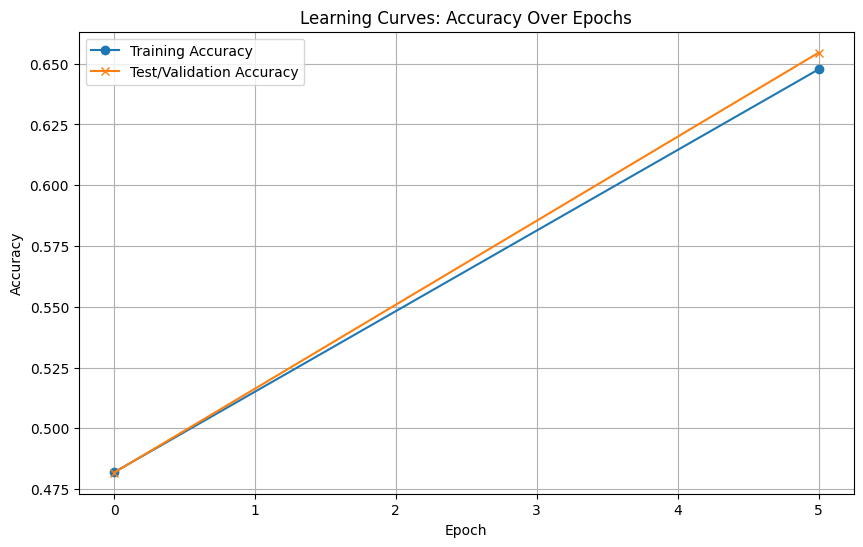


Training Complete. Final Train Acc: 0.6477, Final Test Acc: 0.6545
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6115, Test Acc = 0.6334


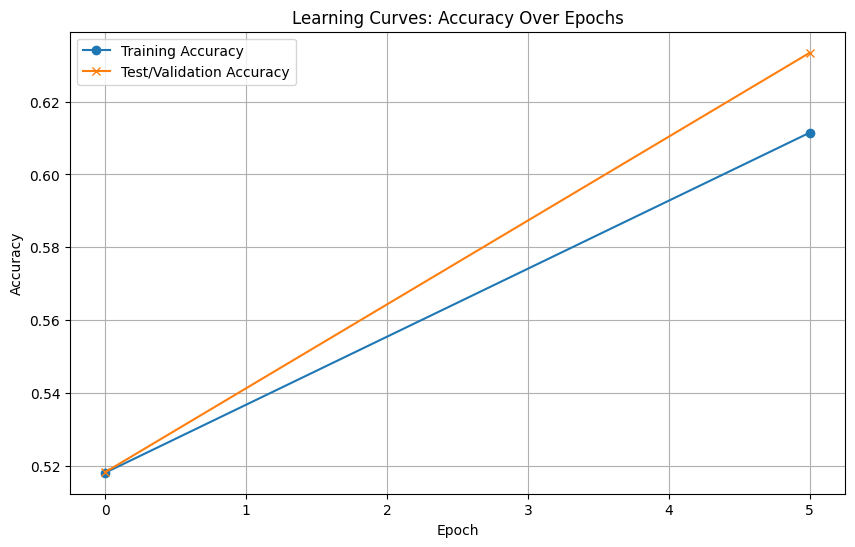


Training Complete. Final Train Acc: 0.6115, Final Test Acc: 0.6334
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6386, Test Acc = 0.6577


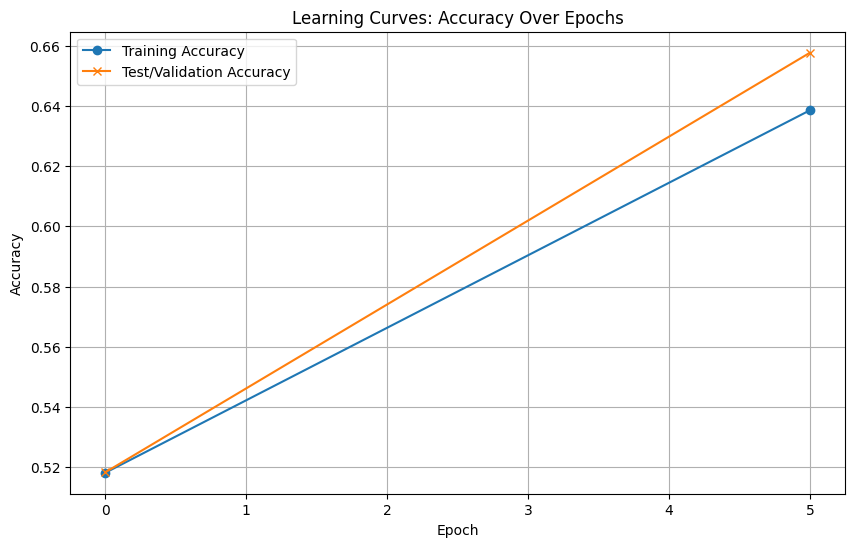


Training Complete. Final Train Acc: 0.6386, Final Test Acc: 0.6577
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6009, Test Acc = 0.6091


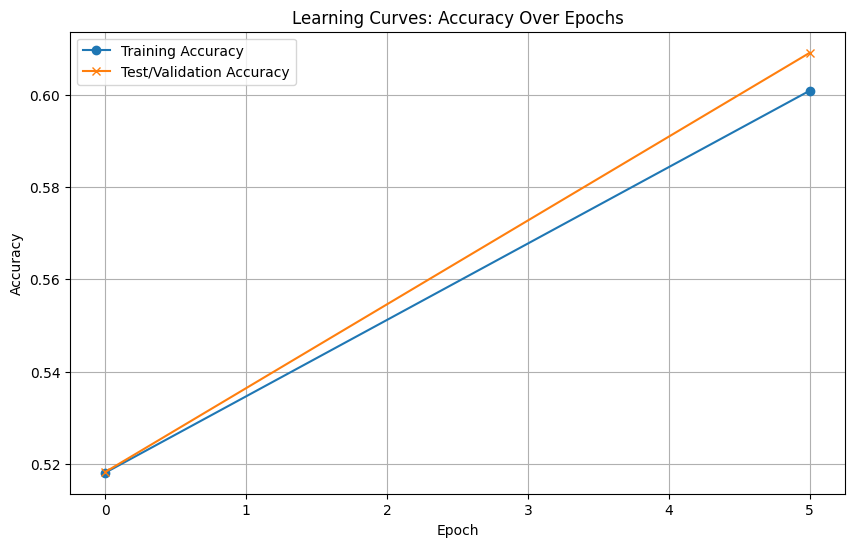


Training Complete. Final Train Acc: 0.6009, Final Test Acc: 0.6091
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6464, Test Acc = 0.6618


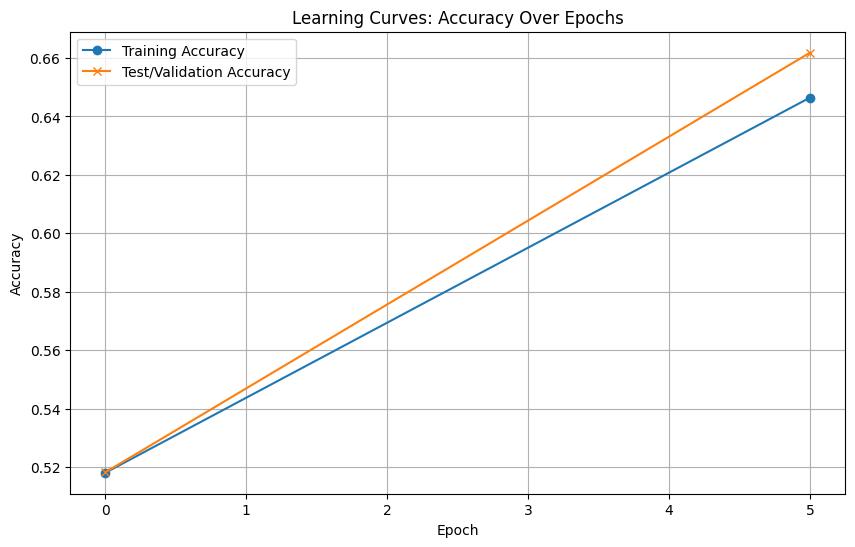


Training Complete. Final Train Acc: 0.6464, Final Test Acc: 0.6618
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6235, Test Acc = 0.6310


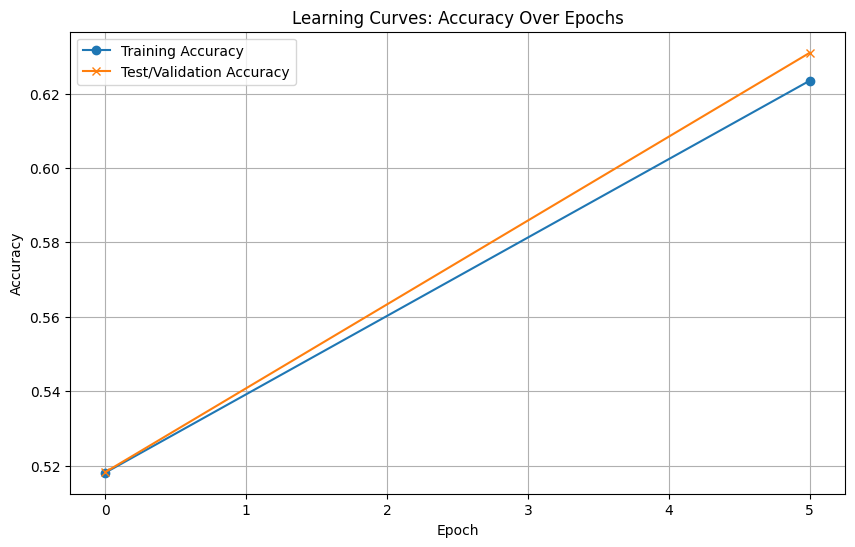


Training Complete. Final Train Acc: 0.6235, Final Test Acc: 0.6310
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6355, Test Acc = 0.6772


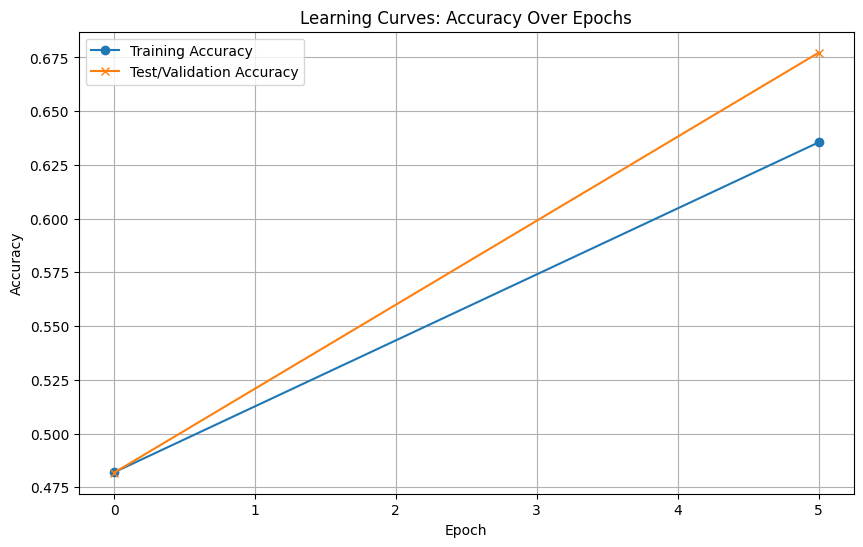


Training Complete. Final Train Acc: 0.6355, Final Test Acc: 0.6772
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6362, Test Acc = 0.6586


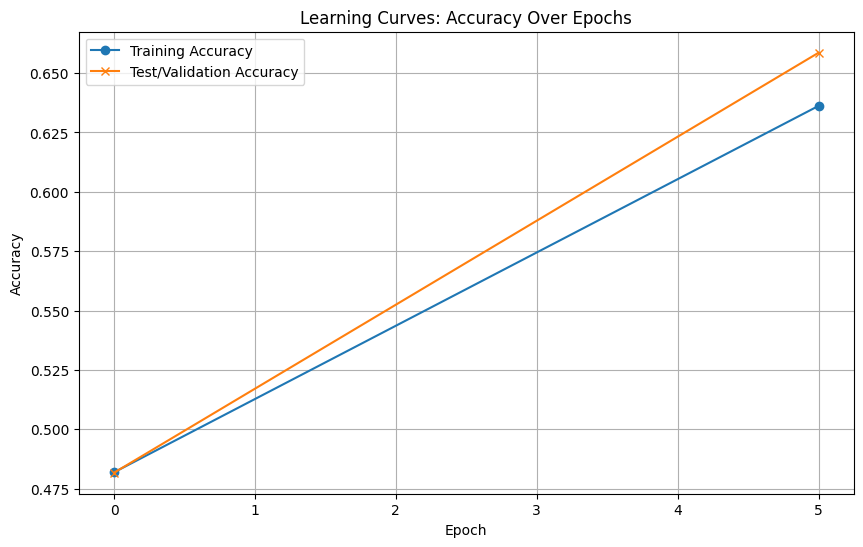


Training Complete. Final Train Acc: 0.6362, Final Test Acc: 0.6586
Epoch 0 (Initial): Train Acc = 0.5104, Test Acc = 0.5158
Epoch 5: Train Acc = 0.6336, Test Acc = 0.6805


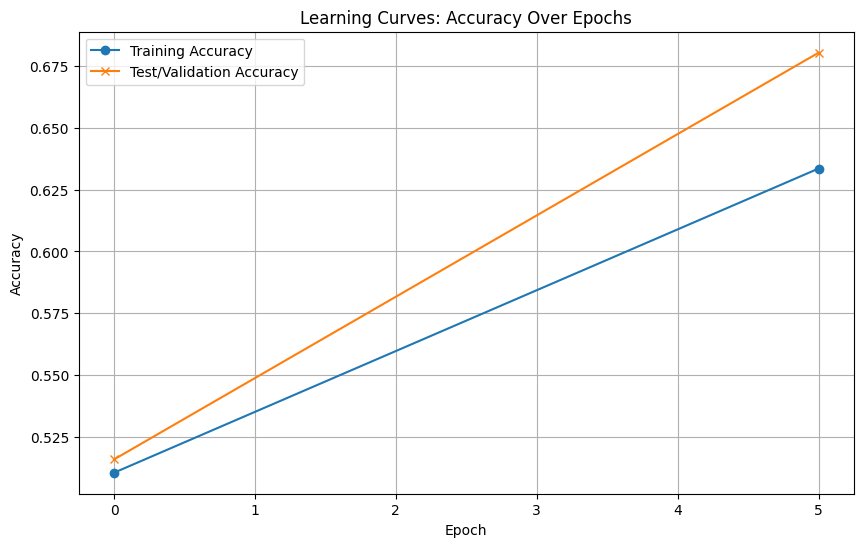


Training Complete. Final Train Acc: 0.6336, Final Test Acc: 0.6805
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6395, Test Acc = 0.6537


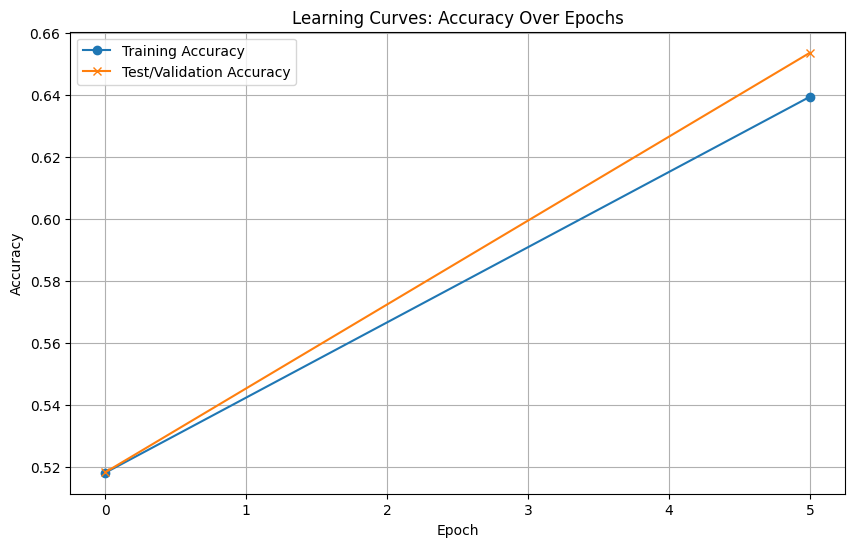


Training Complete. Final Train Acc: 0.6395, Final Test Acc: 0.6537
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.5463, Test Acc = 0.5547


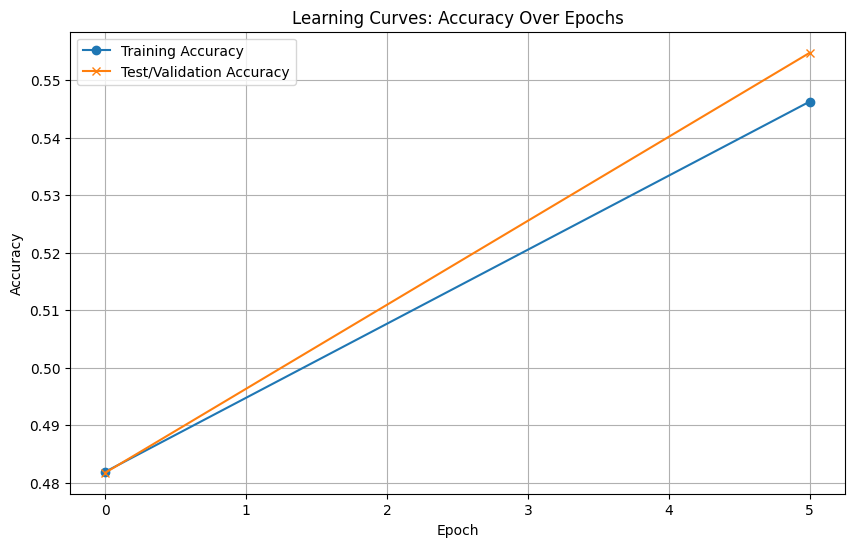


Training Complete. Final Train Acc: 0.5463, Final Test Acc: 0.5547
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6066, Test Acc = 0.6732


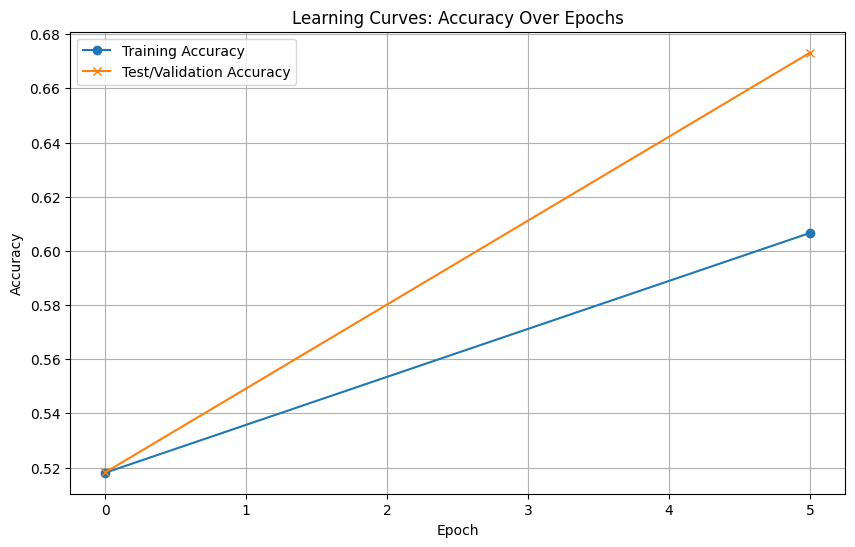


Training Complete. Final Train Acc: 0.6066, Final Test Acc: 0.6732
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6070, Test Acc = 0.6253


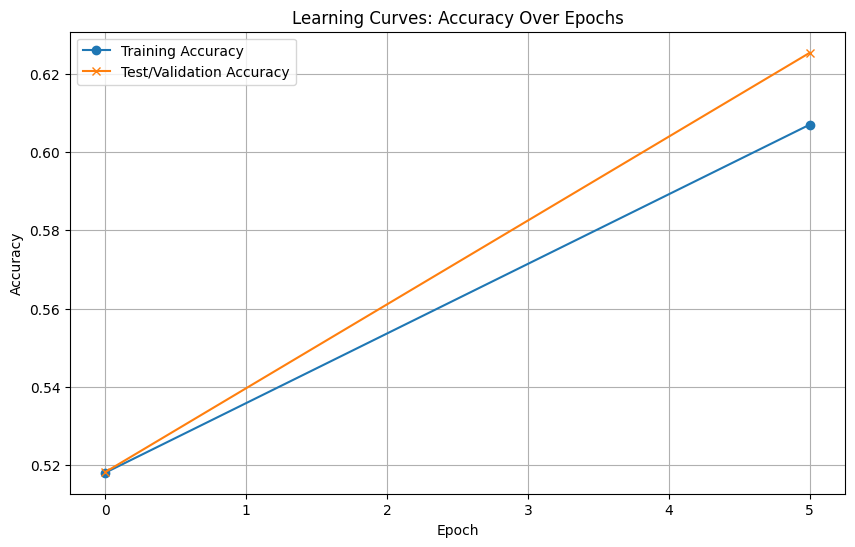


Training Complete. Final Train Acc: 0.6070, Final Test Acc: 0.6253
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6090, Test Acc = 0.6067


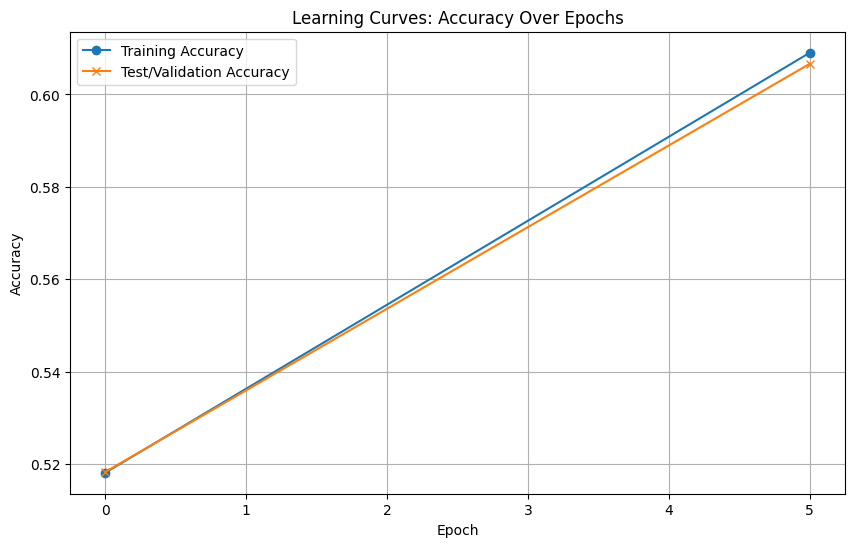


Training Complete. Final Train Acc: 0.6090, Final Test Acc: 0.6067
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6005, Test Acc = 0.6050


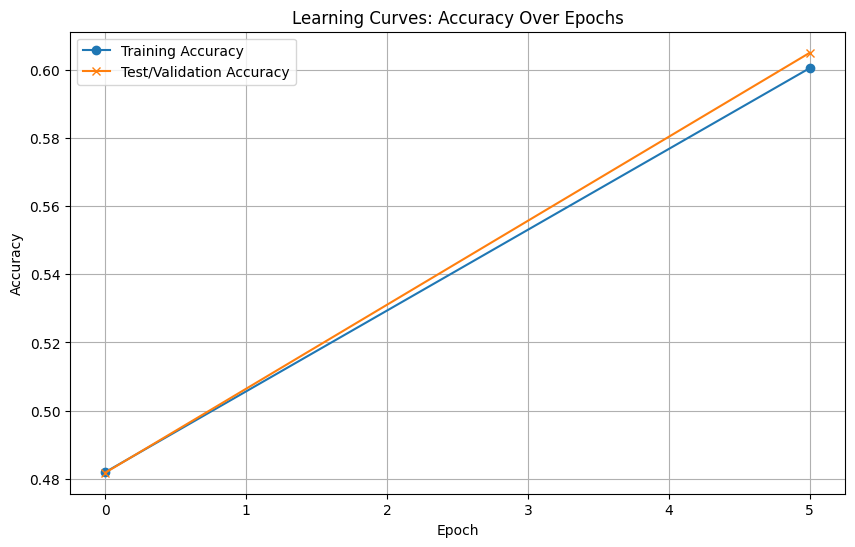


Training Complete. Final Train Acc: 0.6005, Final Test Acc: 0.6050
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.6198, Test Acc = 0.6464


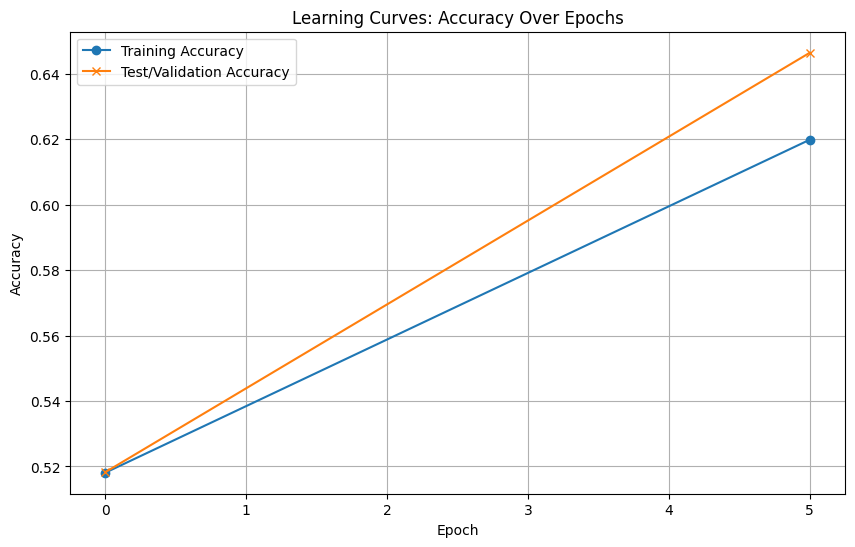


Training Complete. Final Train Acc: 0.6198, Final Test Acc: 0.6464
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6136, Test Acc = 0.6561


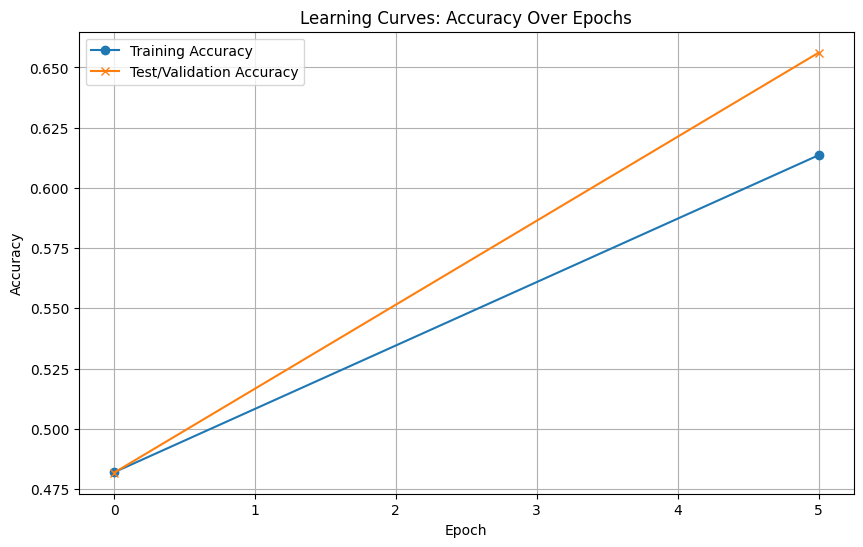


Training Complete. Final Train Acc: 0.6136, Final Test Acc: 0.6561
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6329, Test Acc = 0.6715


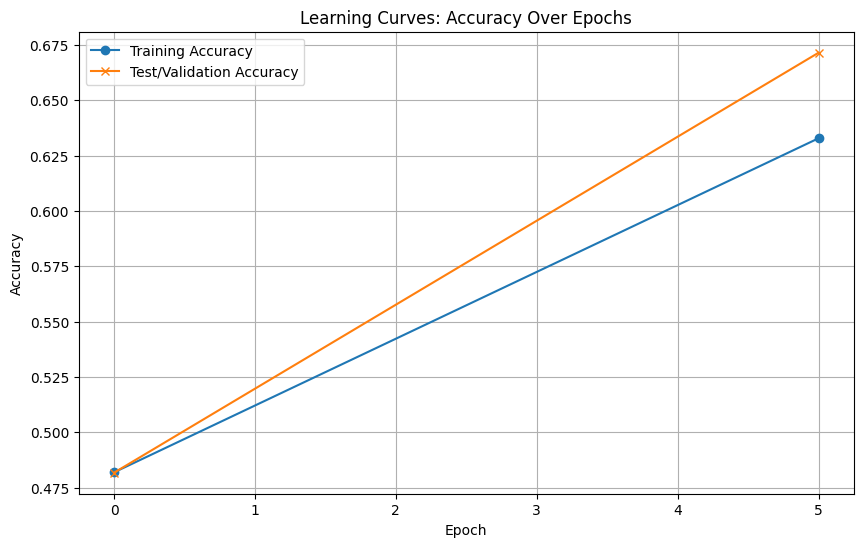


Training Complete. Final Train Acc: 0.6329, Final Test Acc: 0.6715
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.5748, Test Acc = 0.6302


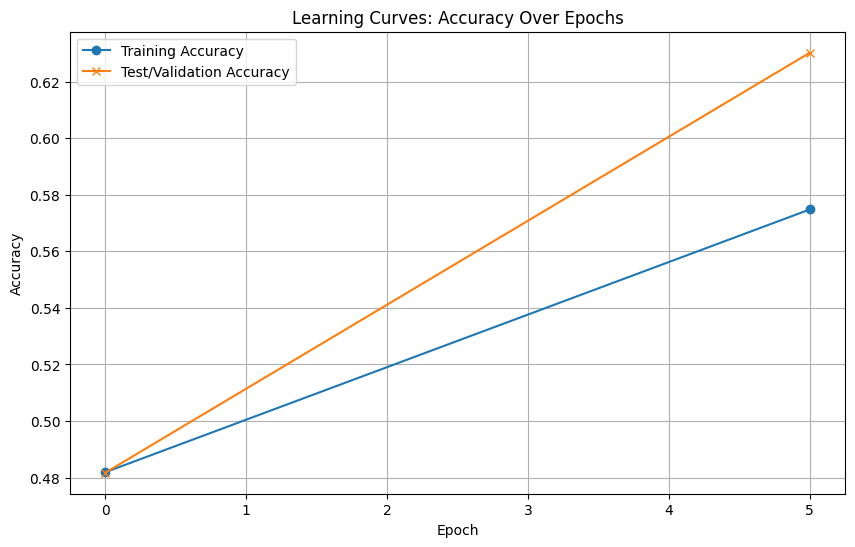


Training Complete. Final Train Acc: 0.5748, Final Test Acc: 0.6302
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.5925, Test Acc = 0.6212


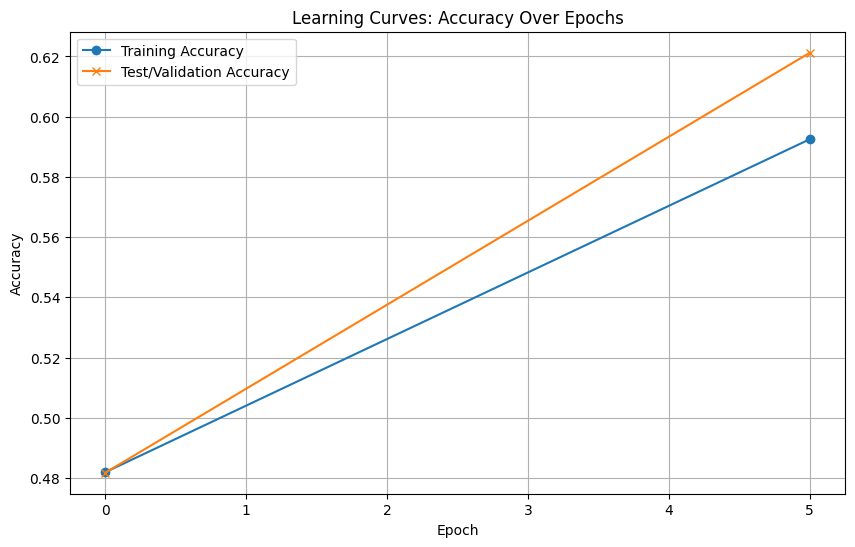


Training Complete. Final Train Acc: 0.5925, Final Test Acc: 0.6212
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6282, Test Acc = 0.6513


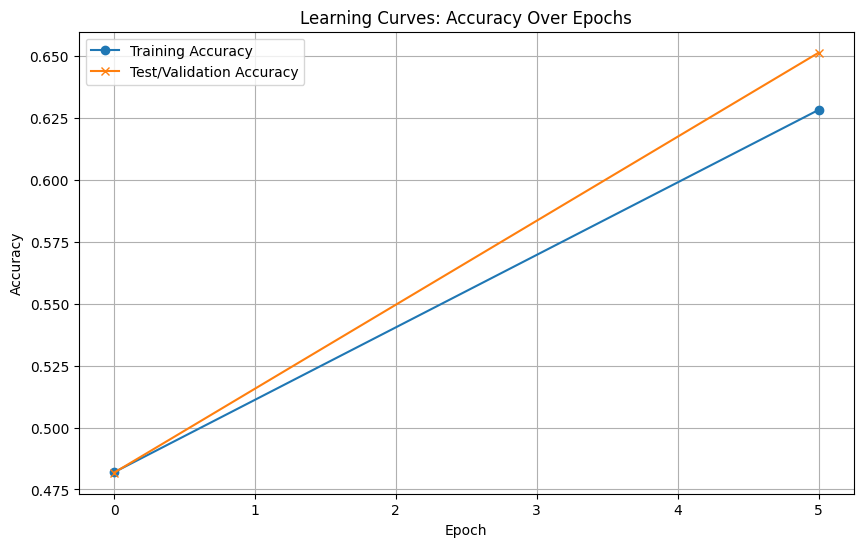


Training Complete. Final Train Acc: 0.6282, Final Test Acc: 0.6513
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.6143, Test Acc = 0.6294


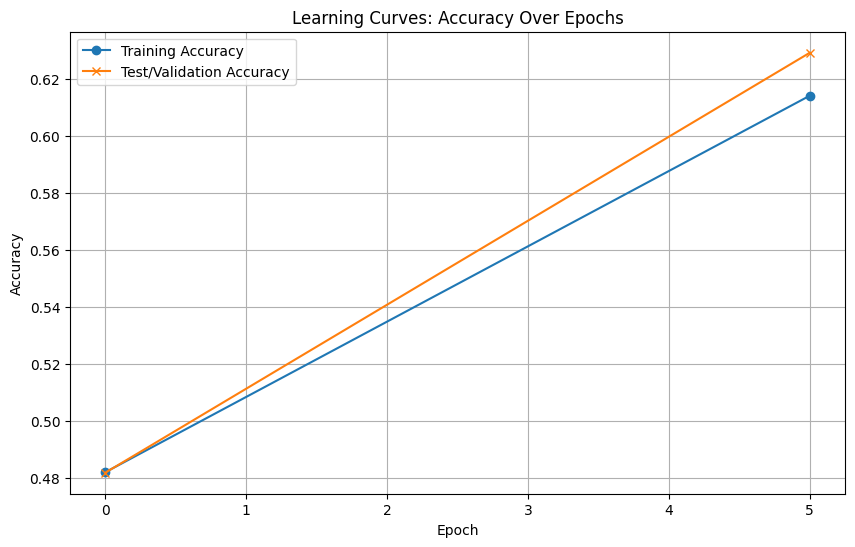


Training Complete. Final Train Acc: 0.6143, Final Test Acc: 0.6294
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 5: Train Acc = 0.5918, Test Acc = 0.6285


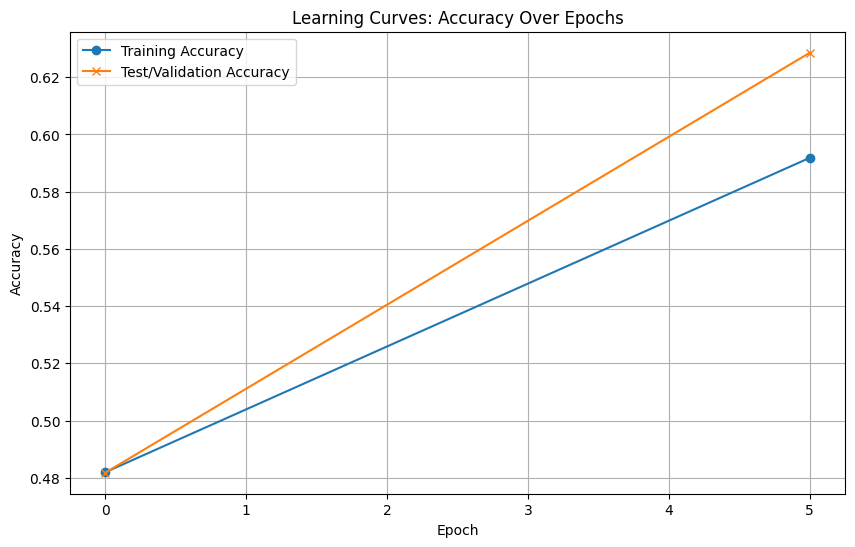


Training Complete. Final Train Acc: 0.5918, Final Test Acc: 0.6285
Epoch 0 (Initial): Train Acc = 0.5181, Test Acc = 0.5182
Epoch 5: Train Acc = 0.5991, Test Acc = 0.6204


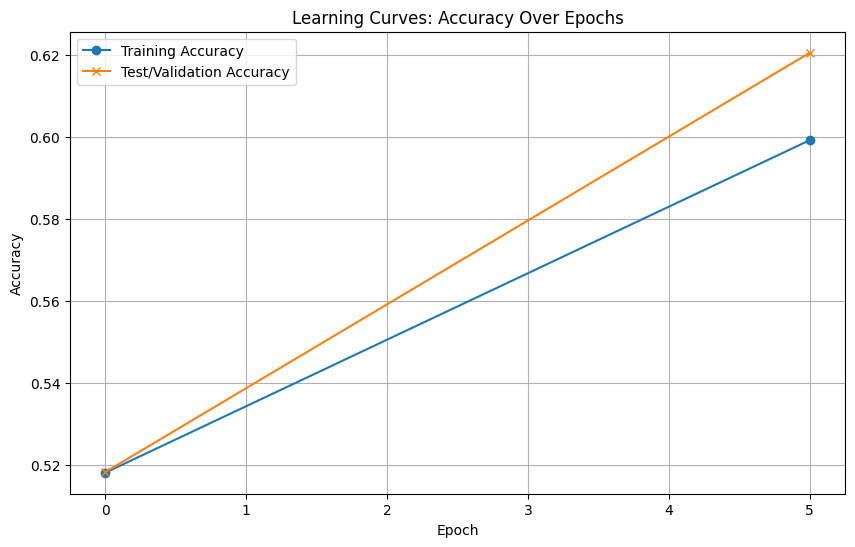


Training Complete. Final Train Acc: 0.5991, Final Test Acc: 0.6204
Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 16.12 MiB is free. Process 13850 has 14.72 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 197.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [36]:
channel_ratio = [1,2,4,8,16]
channel_mag = [16, 32, 64, 128, 256]
for c in channel_ratio:
  for m in channel_mag:
    model = RegNet_any(
      depths=(8, 32),
      channels=(m, c*m),
      groups=16,
      bot_mul=1.0,
      stem_channels = 8
    )
    trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=5)
    parameters = count_parameters(model)['Trainable Parameters']
    channel_size_accs[(c,m)] = (trainacc, valacc, parameters)

In [37]:
channel_size_accs

{(1, 16): (0.6476521739130435, 0.6545012165450121, '119,026'),
 (1, 32): (0.6114782608695652, 0.6334144363341444, '278,770'),
 (1, 64): (0.6386086956521739, 0.6577453365774534, '721,138'),
 (1, 128): (0.6008695652173913, 0.6090835360908353, '2,097,394'),
 (1, 256): (0.6464347826086957, 0.6618004866180048, '6,815,986'),
 (2, 16): (0.6234782608695653, 0.6309813463098135, '246,338'),
 (2, 32): (0.6354782608695653, 0.6772100567721006, '631,186'),
 (2, 64): (0.6361739130434783, 0.6585563665855637, '1,817,138'),
 (2, 128): (0.6335652173913043, 0.6804541768045418, '5,854,066'),
 (2, 256): (0.6394782608695652, 0.6536901865369019, '20,588,018'),
 (4, 16): (0.5462608695652174, 0.5547445255474452, '597,730'),
 (4, 32): (0.6066086956521739, 0.6731549067315491, '1,723,090'),
 (4, 64): (0.6069565217391304, 0.6253041362530414, '5,557,426'),
 (4, 128): (0.6090434782608696, 0.6066504460665044, '19,560,562'),
 (4, 256): (0.6005217391304348, 0.6050283860502839, '72,904,690'),
 (8, 16): (0.619826086956521

Plot saved to test_acc_by_ratio_log.png


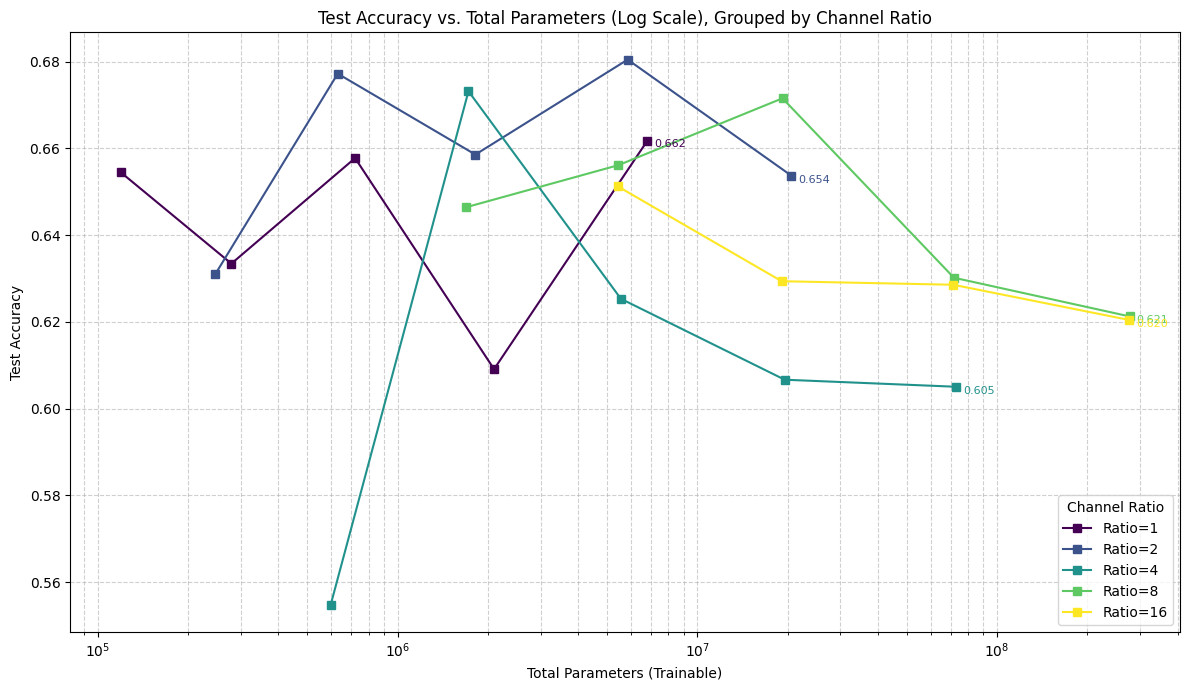

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Union


def plot_accuracy_by_ratio(results_dict: Dict[Tuple[Union[int, float], Union[int, float]],
                                             Tuple[float, float, str]],
                           filename: str = 'test_acc_by_ratio_log.png'): # Changed filename
    """
    Generates a scatter plot with connected lines showing only Test Accuracy
    across Total Parameters (on a log scale), separated by unique Channel Ratios (c).

    Args:
        results_dict: A dictionary where keys are (channel_ratio, channel_magnitude)
                      and values are (train_acc, test_acc, 'param_count_string').
        filename: The name of the file to save the plot to.
    """

    # 1. Prepare data for DataFrame
    data = []
    for (ratio, mag), values in results_dict.items():
        try:
            # Convert parameter count string to integer
            param_count = int(values[2].replace(',', ''))
        except (ValueError, IndexError):
            print(f"Error processing parameters for key ({ratio}, {mag}). Skipping.")
            continue

        data.append({
            'Ratio': ratio,
            'Magnitude': mag,
            'Test Accuracy': values[1],
            'Total Parameters': param_count
        })

    if not data:
        print("No valid data found to plot.")
        return

    df = pd.DataFrame(data)

    # 2. Setup Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    # Get unique ratios for coloring/grouping
    unique_ratios = sorted(df['Ratio'].unique())

    # Define color map for ratios
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_ratios)))

    # 3. Plotting Logic (Only Test Accuracy)
    for i, ratio in enumerate(unique_ratios):
        # Filter data for the current ratio
        df_ratio = df[df['Ratio'] == ratio].sort_values(by='Total Parameters')

        # Plot Test Accuracy
        ax.plot(df_ratio['Total Parameters'], df_ratio['Test Accuracy'],
                marker='s', linestyle='-', color=colors[i],
                label=f'Ratio={ratio}', alpha=1.0)

        # Add labels to the ends of the lines for clarity
        last_test_acc = df_ratio['Test Accuracy'].iloc[-1]
        last_params = df_ratio['Total Parameters'].iloc[-1]

        # Label Test Accuracy line end
        ax.annotate(f'{last_test_acc:.3f}',
                    (last_params, last_test_acc),
                    textcoords="offset points", xytext=(5, -5), ha='left', fontsize=8, color=colors[i])

    # 4. Final Formatting
    ax.set_title('Test Accuracy vs. Total Parameters (Log Scale), Grouped by Channel Ratio')
    ax.set_xlabel('Total Parameters (Trainable)')
    ax.set_ylabel('Test Accuracy')

    # Apply Log Scale to X-axis
    ax.set_xscale('log')

    ax.legend(title='Channel Ratio', loc='lower right')
    ax.grid(True, linestyle='--', alpha=0.6, which='both') # Added which='both' for log scale

    fig.tight_layout()
    plt.savefig(filename)
    print(f"Plot saved to {filename}")

# Execute the function with dummy data
plot_accuracy_by_ratio(channel_size_accs)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, Union

def plot_cdf_by_group(results_dict: Dict[Tuple[Union[int, float], Union[int, float]],
                                             Tuple[float, float, str]],
                            group_by: str = 'Ratio',
                            accuracy_metric: str = 'Test Accuracy',
                            filename: str = 'cdf_plot_fixed.png'):

    # 1. Prepare data for DataFrame
    data = []
    for (ratio, mag), values in results_dict.items():
        data.append({
            'Ratio': ratio, 'Magnitude': mag, 'Train Accuracy': values[0], 'Test Accuracy': values[1]
        })

    if not data:
        print("No valid data found to plot.")
        return

    df = pd.DataFrame(data)

    # 2. Setup Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Get unique groups and define color map
    unique_groups = sorted(df[group_by].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))

    # 3. Plotting Logic
    for i, group_value in enumerate(unique_groups):
        df_group = df[df[group_by] == group_value].copy()
        sorted_acc = df_group[accuracy_metric].sort_values().values
        N = len(sorted_acc)
        y_cdf = np.arange(1, N + 1) / N

        ax.plot(sorted_acc, y_cdf,
                marker='.',
                linestyle='-',
                color=colors[i],
                label=f'{group_by}={group_value}',
                alpha=0.8)

    # 4. Final Formatting
    ax.set_title(f'Cumulative Distribution Function of {accuracy_metric} (Grouped by {group_by})')
    ax.set_xlabel(f'{accuracy_metric}')
    # FIX APPLIED: Using MathText syntax (r'$...$') for the entire label
    ax.set_ylabel(f'Cumulative Probability (P(X ≤ x))')
    ax.legend(title=group_by, loc='lower right')
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.set_ylim(0, 1.05)

    fig.tight_layout()
    plt.savefig(filename)
    print(f"Plot saved to {filename}")

Plot saved to cdf_test_acc_by_ratio.png


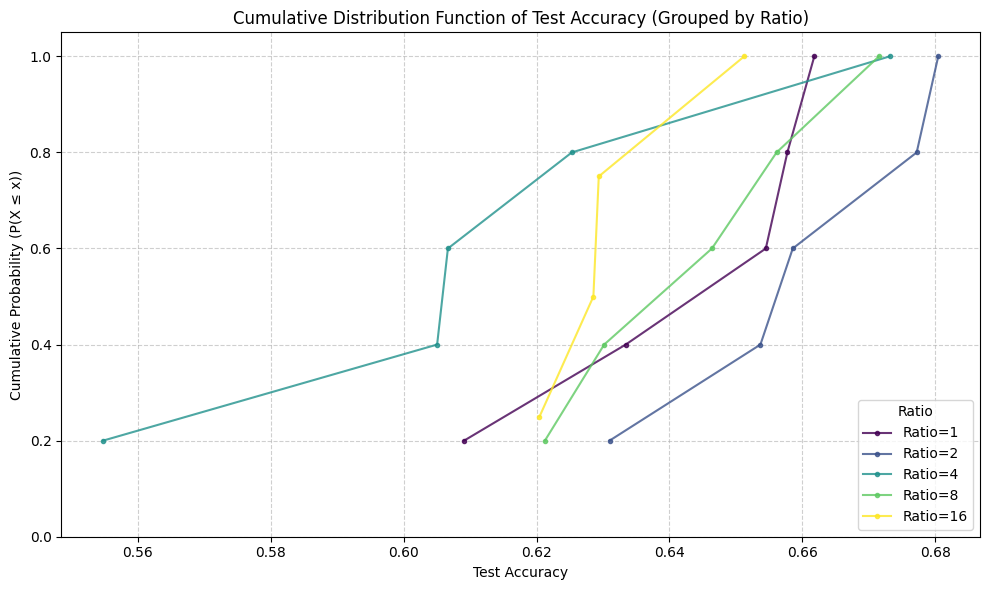

In [46]:
plot_cdf_by_group(results_dict=channel_size_accs, group_by='Ratio', filename='cdf_test_acc_by_ratio.png')

Plot saved to cdf_test_acc_by_magnitude.png


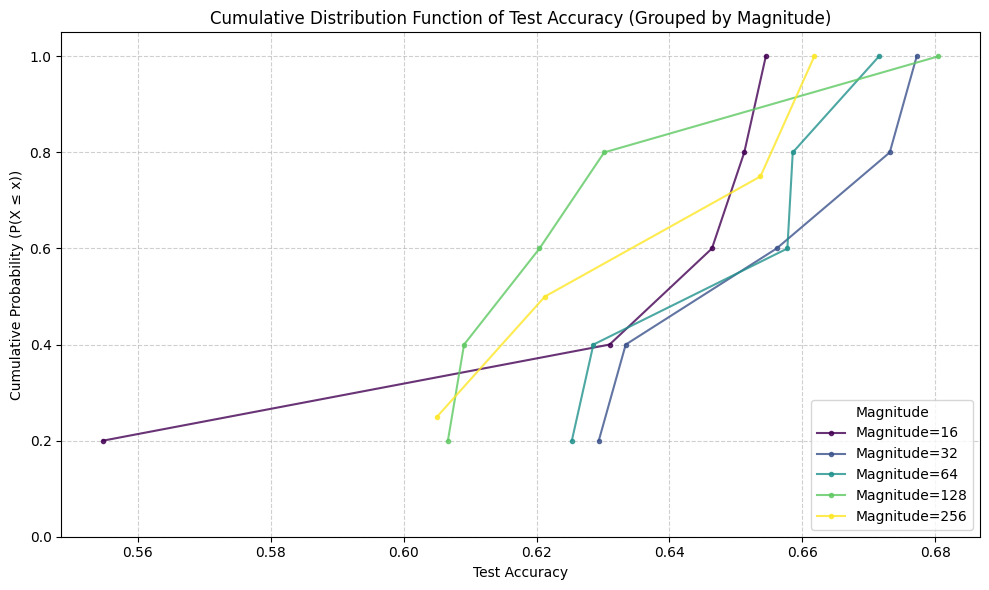

In [47]:
plot_cdf_by_group(results_dict=channel_size_accs, group_by='Magnitude', filename='cdf_test_acc_by_magnitude.png')

Epoch 0 (Initial): Train Acc = 0.4819, Test Acc = 0.4818
Epoch 10: Train Acc = 0.7130, Test Acc = 0.7032
Epoch 20: Train Acc = 0.7670, Test Acc = 0.7486
Epoch 30: Train Acc = 0.7957, Test Acc = 0.7624
Epoch 40: Train Acc = 0.8193, Test Acc = 0.7624


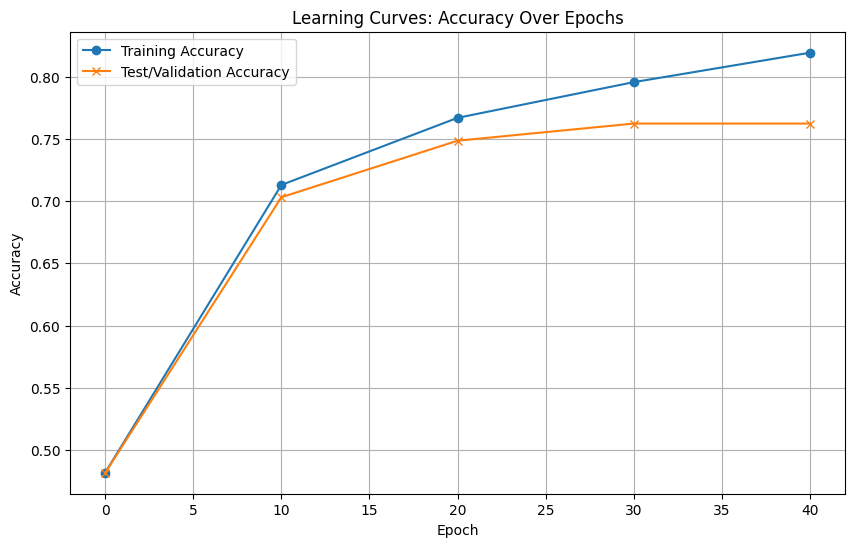


Training Complete. Final Train Acc: 0.8193, Final Test Acc: 0.7624


In [52]:
del model
model = RegNet_any(
      depths=(4, 6, 8),
      channels=(32,32*2,32*2*2),
      groups=16,
      bot_mul=1.0,
      stem_channels = 8
    )
trainacc, valacc = train_CNN(model, combined_train_loader, val_loader, device=torch.device("cuda"), num_epochs=40)

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple, Union

# Conceptual Update to your external 'evaluate' function

# You need to install scikit-learn or torchmetrics
from sklearn.metrics import f1_score
# or from torchmetrics import F1Score

# Assuming this is your separate evaluate function (or similar logic)

import torch
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from typing import Tuple

def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             device: torch.device) -> Tuple[float, float]:
    """
    Evaluates the model on the given DataLoader and returns both Accuracy and F1 Score.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:

            # --- FIX: Robust Batch Unpacking and Device Transfer (Essential) ---
            if isinstance(batch, dict):
                X_batch = batch.get('image')
                y_batch = batch.get('label')
            elif isinstance(batch, (list, tuple)):
                X_batch, y_batch = batch[0], batch[1]
            else:
                # Skip batch if format is unexpected
                continue

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # ------------------------------------------------------------------

            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)

            # Store predictions and true labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert lists to NumPy arrays
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # 1. Calculate Accuracy
    final_accuracy = accuracy_score(true_labels, predicted_labels)

    # 2. Calculate F1 Score
    # 'weighted' is usually the most appropriate average for multi-class classification
    # to account for class imbalance by weighting the F1 score of each class by its support.
    final_f1_score = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

    return final_accuracy, final_f1_score

In [56]:
def final_train_CNN(model: nn.Module,
                    trainloader: torch.utils.data.DataLoader,
                    testloader: torch.utils.data.DataLoader,
                    num_epochs: int = 50,
                    lr: float = 0.01,
                    device: torch.device = None) -> Tuple[float, float]: # <-- UPDATED RETURN TYPE
    """
    Trains a CNN model for a fixed number of epochs and performs a single
    final evaluation using the testloader, returning both accuracy and F1 score.

    Args:
        model (nn.Module): The CNN model to train.
        trainloader (DataLoader): DataLoader for the training data (Train + Val combined).
        testloader (DataLoader): DataLoader for the final test data.
        num_epochs (int): The total number of epochs to train.
        lr (float): Learning rate for the optimizer.
        device (torch.device, optional): The device to use for training.

    Returns:
        Tuple[float, float]: A tuple containing the final (test_accuracy, test_f1_score).
    """
    # 1. Device Setup
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Warning: 'device' not passed. Defaulting to {device}.")

    # 2. Move Model to Device
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    print(f"Starting final training for {num_epochs} epochs on {device}...")

    # ----------------- TRAINING LOOP -----------------
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(trainloader):
            # --- Robust Batch Unpacking ---
            if isinstance(batch, dict):
                X_batch = batch.get('image')
                y_batch = batch.get('label')
            elif isinstance(batch, (list, tuple)):
                X_batch, y_batch = batch[0], batch[1]
            else:
                raise TypeError(f"Unexpected batch type yielded by trainloader: {type(batch)}.")
            # ------------------------------

            # --- Move data to the device ---
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # -------------------------------

            # --- Standard Training Steps ---
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print loss summary for epoch (optional, but good for tracking progress)
        print(f"Epoch {epoch}/{num_epochs} Loss: {running_loss / len(trainloader):.4f}")

    # ----------------- FINAL EVALUATION -----------------
    print("\nTraining complete. Starting final Test Set evaluation...")

    model.eval()

    # <--- CHANGE HERE: Unpack the returned tuple (acc, f1) --->
    # NOTE: This assumes you have updated your external 'evaluate' function
    final_test_acc, final_test_f1 = evaluate(model, testloader, device)

    print(f"Final Test Accuracy: {final_test_acc:.4f}")
    print(f"Final Test F1 Score: {final_test_f1:.4f}") # <-- NEW OUTPUT

    # <--- CHANGE HERE: Return both metrics --->
    return final_test_acc, final_test_f1

In [66]:
from loaders import create_loaders

TARGET_SIZE = 50
PROJECT_DIR = '/content/fast_data/'

brightness_aug_combined = transforms.ColorJitter(brightness=0.5, contrast=0.0, saturation=0.0, hue=0.0)

train_transforms_combined = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    brightness_aug_combined,
    transforms.ToTensor(),
])

eval_transforms_deterministic = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.ToTensor(),
])


# 2. Call the function for final deployment
# final_combined_loader = (Train + Val) using augmented transforms
# final_test_loader_det = Test using deterministic transforms
final_combined_loader, _, final_test_loader_det = create_loaders(
    df_master, # Your master DataFrame
    patch_dir=PROJECT_DIR,
    filters=custom_filter,
    train_transform=train_transforms_combined,      # Applied to Train + Val
    eval_transform=eval_transforms_deterministic,    # Applied to Test
    final_train=True # Activates combination mode
)

print(f"Final Train+Val Loader ready: {len(final_combined_loader.dataset)} samples.")
print(f"Final Test Loader ready: {len(final_test_loader_det.dataset)} samples.")


--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

--- Final Training Mode Activated (Train + Val Combined) ---

DataLoaders created successfully.
Train Loader batch size: 32
Final Train+Val Loader ready: 6983 samples.
Final Test Loader ready: 1233 samples.


In [67]:
del model
model = RegNet_any(
      depths=(4, 6, 8),
      channels=(32,32*2,32*2*2),
      groups=16,
      bot_mul=1.0,
      stem_channels = 8
    )
testacc = final_train_CNN(model, final_combined_loader, final_test_loader_det, device=torch.device("cuda"), num_epochs=30)

Starting final training for 30 epochs on cuda...
Epoch 1/30 Loss: 0.8193
Epoch 2/30 Loss: 0.6990
Epoch 3/30 Loss: 0.6811
Epoch 4/30 Loss: 0.6440
Epoch 5/30 Loss: 0.6205
Epoch 6/30 Loss: 0.5978
Epoch 7/30 Loss: 0.5950
Epoch 8/30 Loss: 0.5662
Epoch 9/30 Loss: 0.5500
Epoch 10/30 Loss: 0.5485
Epoch 11/30 Loss: 0.5372
Epoch 12/30 Loss: 0.5298
Epoch 13/30 Loss: 0.5038
Epoch 14/30 Loss: 0.5069
Epoch 15/30 Loss: 0.4976
Epoch 16/30 Loss: 0.4835
Epoch 17/30 Loss: 0.4862
Epoch 18/30 Loss: 0.4756
Epoch 19/30 Loss: 0.4743
Epoch 20/30 Loss: 0.4797
Epoch 21/30 Loss: 0.4623
Epoch 22/30 Loss: 0.4577
Epoch 23/30 Loss: 0.4530
Epoch 24/30 Loss: 0.4442
Epoch 25/30 Loss: 0.4411
Epoch 26/30 Loss: 0.4330
Epoch 27/30 Loss: 0.4207
Epoch 28/30 Loss: 0.4191
Epoch 29/30 Loss: 0.4142
Epoch 30/30 Loss: 0.4132

Training complete. Starting final Test Set evaluation...


NameError: name 'X_batch' is not defined

In [73]:
model.eval()

# <--- CHANGE HERE: Unpack the returned tuple (acc, f1) --->
# NOTE: This assumes you have updated your external 'evaluate' function
final_test_acc, final_test_f1 = evaluate(model, final_test_loader_det, device=torch.device("cuda"))

print(f"Final Test Accuracy: {final_test_acc:.4f}")
print(f"Final Test F1 Score: {final_test_f1:.4f}") # <-- NEW OUTPUT


Final Test Accuracy: 0.7583
Final Test F1 Score: 0.7562
